<a href="https://colab.research.google.com/github/annalimm/MultiTimeSeries_Transformer/blob/main/MultiTimeSer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yahoofinancials

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

from yahoofinancials import YahooFinancials
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn')

<ipython-input-3-57db251bb9d0>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Data

In [4]:
def get_historical_stock_data(ticker: str, start_date, end_date):
    try:
        raw_data = YahooFinancials(ticker)
        historical_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
        prices = historical_data.get(ticker, {}).get("prices", [])  # Necessary block of stocks data
        if not prices:
            return pd.DataFrame()
        df = pd.DataFrame(prices)
        df['date'] = pd.to_datetime(df['formatted_date'] + ' 14:30:00')  # investigate which time of the day is the best
        df = df[['date', 'open', 'high', 'low', 'adjclose', 'volume']]
        df['volume'].replace(to_replace=0, method='ffill', inplace=True) # Replace 0 to avoid dividing by 0 later on
        df.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
        #df.set_index('DateTime', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return pd.DataFrame()  # Return an empty DataFrame if no data is available


def fetch_tickers_data(tickers: list, start_date, end_date) -> pd.DataFrame:
    data_frames = []

    for ticker in tickers:
        ticker_data = get_historical_stock_data(ticker, start_date, end_date)
        if len(tickers) > 1 and not ticker_data.empty:
            ticker_data['Ticker'] = ticker  # Add a 'ticker' column to identify each ticker
        data_frames.append(ticker_data)

    if data_frames:
        concatenated_data = pd.concat(data_frames)
        return concatenated_data
    return pd.DataFrame()

We dont need more than one stock yet. We already have multivariate time series

But it's a good idea to study trends from few stocks later

In [5]:
# tickers = ['AAPL', 'META', 'MSFT']
tickers = ['IBM']
start_date = '1960-01-01'
end_date = '2022-02-25'

stocks_data = fetch_tickers_data(tickers, start_date, end_date)
print(stocks_data)

                 DateTime        Open        High         Low       Close  \
0     1962-01-02 14:30:00    7.374124    7.374124    7.291268    1.573409   
1     1962-01-03 14:30:00    7.291268    7.355003    7.291268    1.587164   
2     1962-01-04 14:30:00    7.355003    7.355003    7.278521    1.571348   
3     1962-01-05 14:30:00    7.272148    7.272148    7.125558    1.540401   
4     1962-01-08 14:30:00    7.131931    7.131931    6.947100    1.511518   
...                   ...         ...         ...         ...         ...   
15137 2022-02-17 14:30:00  128.050003  128.500000  124.849998  116.099709   
15138 2022-02-18 14:30:00  124.940002  125.440002  123.610001  115.523712   
15139 2022-02-22 14:30:00  124.199997  125.000000  122.680000  115.124229   
15140 2022-02-23 14:30:00  124.379997  124.699997  121.870003  113.405548   
15141 2022-02-24 14:30:00  120.000000  122.099998  118.809998  113.312637   

        Volume  
0       407940  
1       305955  
2       274575  
3      

In [6]:
def stock_plot(stock_str, df):
  fig = plt.figure(figsize=(15,10))
  st = fig.suptitle(stock_str, fontsize=20)
  st.set_y(0.92)

  ax1 = fig.add_subplot(211)
  ax1.plot(df['Close'], label='Close Price')
  ax1.set_xticks(range(0, df.shape[0], 1464))
  #ax1.set_xticklabels(df['DateTime'].dt.strftime('%Y-%m-%d').loc[::1464])
  ax1.set_ylabel('Close Price', fontsize=18)
  ax1.legend(loc="upper left", fontsize=12)

  ax2 = fig.add_subplot(212)
  ax2.plot(df['Volume'], label='Volume')
  ax2.set_xticks(range(0, df.shape[0], 1464))
  #ax2.set_xticklabels(df['DateTime'].dt.strftime('%Y-%m-%d').loc[::1464])
  ax2.set_ylabel('Volume', fontsize=18)
  ax2.legend(loc="upper left", fontsize=12)

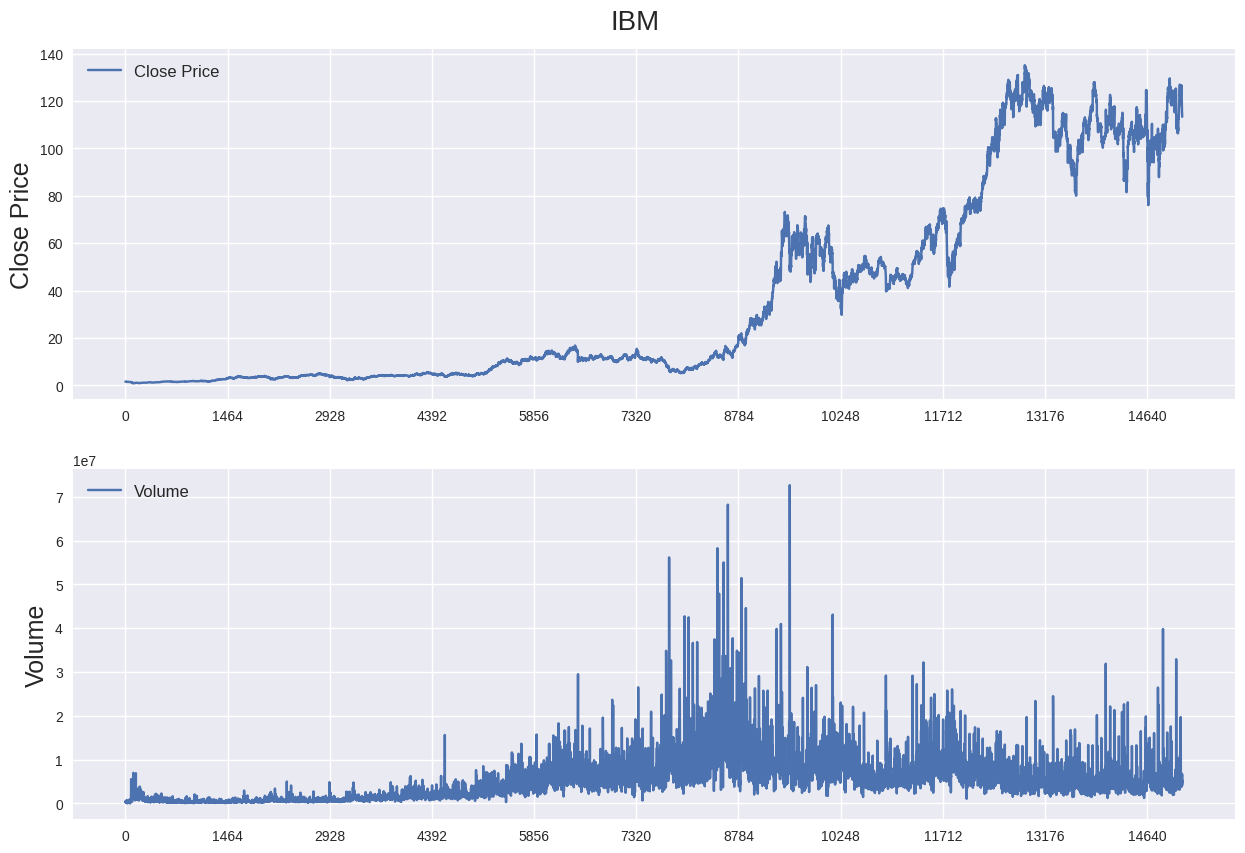

In [7]:
stock_plot("IBM", stocks_data)

# Data engineering

## data converting

In [8]:
# Data converts for better stationarity:
# price converts to daily stock returns and volume converts to daily volume changes

def df_convert(stock_df):
  df = pd.DataFrame()
  # the percentage change between the current element and the previous element
  df['Open'] = stock_df['Open'].pct_change()
  df['High'] = stock_df['High'].pct_change()
  df['Low'] = stock_df['Low'].pct_change()
  df['Close'] = stock_df['Close'].pct_change()
  df['Volume'] = stock_df['Volume'].pct_change()

  df.dropna(how='any', axis=0, inplace=True)
  return df

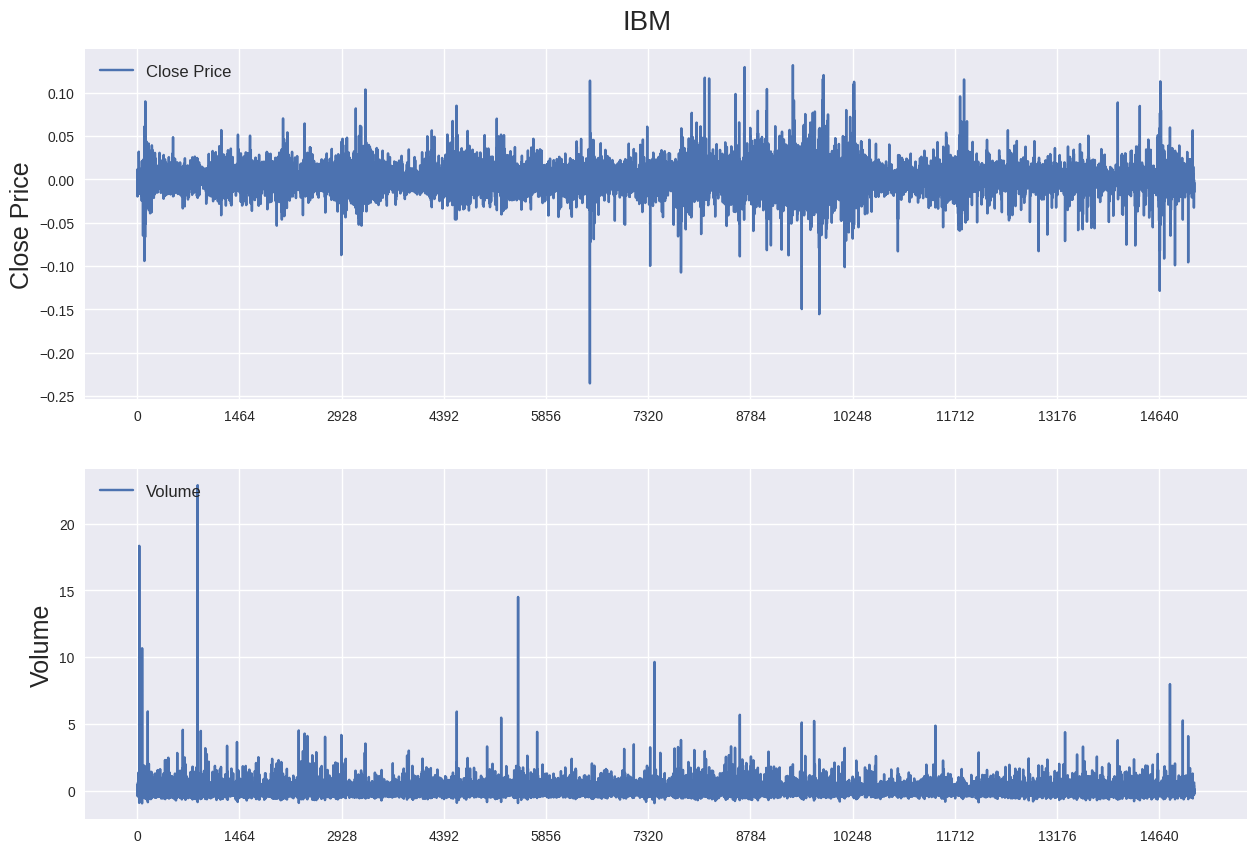

In [9]:
conv_df = df_convert(stocks_data)
stock_plot("IBM", conv_df)

## min-max normalization

important not only in terms of understandability of results, but also for training itself

activations (the result of applying a weighted sum of the inputs, followed by an activation function (e.g., ReLU, sigmoid, or tanh)) can become very large or very small during forward and backward passes.  

Large activations can lead to gradients that explode, making it challenging to train the network. On the other hand, very small activations can result in vanishing gradients, which hinder learning.

We normalise train data relying only on test data, so that it will not give us the information from the future and there will be no data leakage

In [10]:
# i do not entirely understand, why this type of normalization gives a small mape;
# it's muuuch better comparing with norm-ion with min/max counting for every column separately
def mm_norm(df):
  min_return = min(df[: int(len(df)*0.8)][['Open', 'High', 'Low', 'Close']].min(axis=0))
  max_return = max(df[: int(len(df)*0.8)][['Open', 'High', 'Low', 'Close']].max(axis=0))
  min_volume = df[: int(len(df)*0.8)]['Volume'].min(axis=0)
  max_volume = df[: int(len(df)*0.8)]['Volume'].max(axis=0)

  # normilize price columns (0-1 range)
  df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
  df['High'] = (df['High'] - min_return) / (max_return - min_return)
  df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
  df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

  # normilize volume columns (0-1 range)
  df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
  return df

In [11]:
preproc_df = mm_norm(conv_df)

## train, test, validation data

In [12]:
def df_split(df):
  # we maintain chronological order for time-series
  train_samples = int(len(df) * 0.8)
  val_samples = int(len(df) * 0.1)

  df_train = df[:train_samples]
  df_val = df[train_samples: train_samples + val_samples]
  df_test = df[train_samples + val_samples:]

  # remove date column (now we'll do just like that, but maybe later we can somehow use data better - time2Vec?)
  df_train = df_train.loc[:, df_train.columns != 'DateTime']
  df_val = df_val.loc[:, df_val.columns != 'DateTime']
  df_test = df_test.loc[:, df_test.columns != 'DateTime']

  print('Train df shape: {}'.format(df_train.shape))
  print('Val df shape: {}'.format(df_val.shape))
  print('Test df shape: {}'.format(df_test.shape))
  return df_train, df_val, df_test

  # # convert pd colums inro arrays for Transformer
  # arr_train = df_train.values
  # arr_val = df_val.values
  # arr_test = df_test.values

  # print('Train arr shape: {}'.format(arr_train.shape))
  # print('Test arr shape: {}'.format(arr_val.shape))
  # print('Val arr shape: {}'.format(arr_test.shape))
  # return df_train, df_val, df_test, arr_train, arr_val, arr_test

In [13]:
# df_train, df_val, df_test, arr_train, arr_val, arr_test = df_split(preproc_df)
df_train, df_val, df_test = df_split(preproc_df)

Train df shape: (12112, 5)
Val df shape: (1514, 5)
Test df shape: (1515, 5)


In [14]:
def split_plot(df_train, df_val, df_test):
  fig = plt.figure(figsize=(15,12))
  st = fig.suptitle("Data Separation", fontsize=20)
  st.set_y(0.95)

  ax1 = fig.add_subplot(211)
  ax1.plot(np.arange(df_train.shape[0]), df_train['Close'], label='Training data')

  ax1.plot(np.arange(df_train.shape[0],
                    df_train.shape[0]+df_val.shape[0]), df_val['Close'], label='Validation data')

  ax1.plot(np.arange(df_train.shape[0]+df_val.shape[0],
                    df_train.shape[0]+df_val.shape[0]+df_test.shape[0]), df_test['Close'], label='Test data')
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Normalized Closing Returns')
  ax1.set_title("Close Price", fontsize=18)
  ax1.legend(loc="best", fontsize=12)

  ax2 = fig.add_subplot(212)
  ax2.plot(np.arange(df_train.shape[0]), df_train['Volume'], label='Training data')

  ax2.plot(np.arange(df_train.shape[0],
                    df_train.shape[0]+df_val.shape[0]), df_val['Volume'], label='Validation data')

  ax2.plot(np.arange(df_train.shape[0]+df_val.shape[0],
                    df_train.shape[0]+df_val.shape[0]+df_test.shape[0]), df_test['Volume'], label='Test data')
  ax2.set_xlabel('Date')
  ax2.set_ylabel('Normalized Volume Changes')
  ax2.set_title("Volume", fontsize=18)
  ax2.legend(loc="best", fontsize=12)

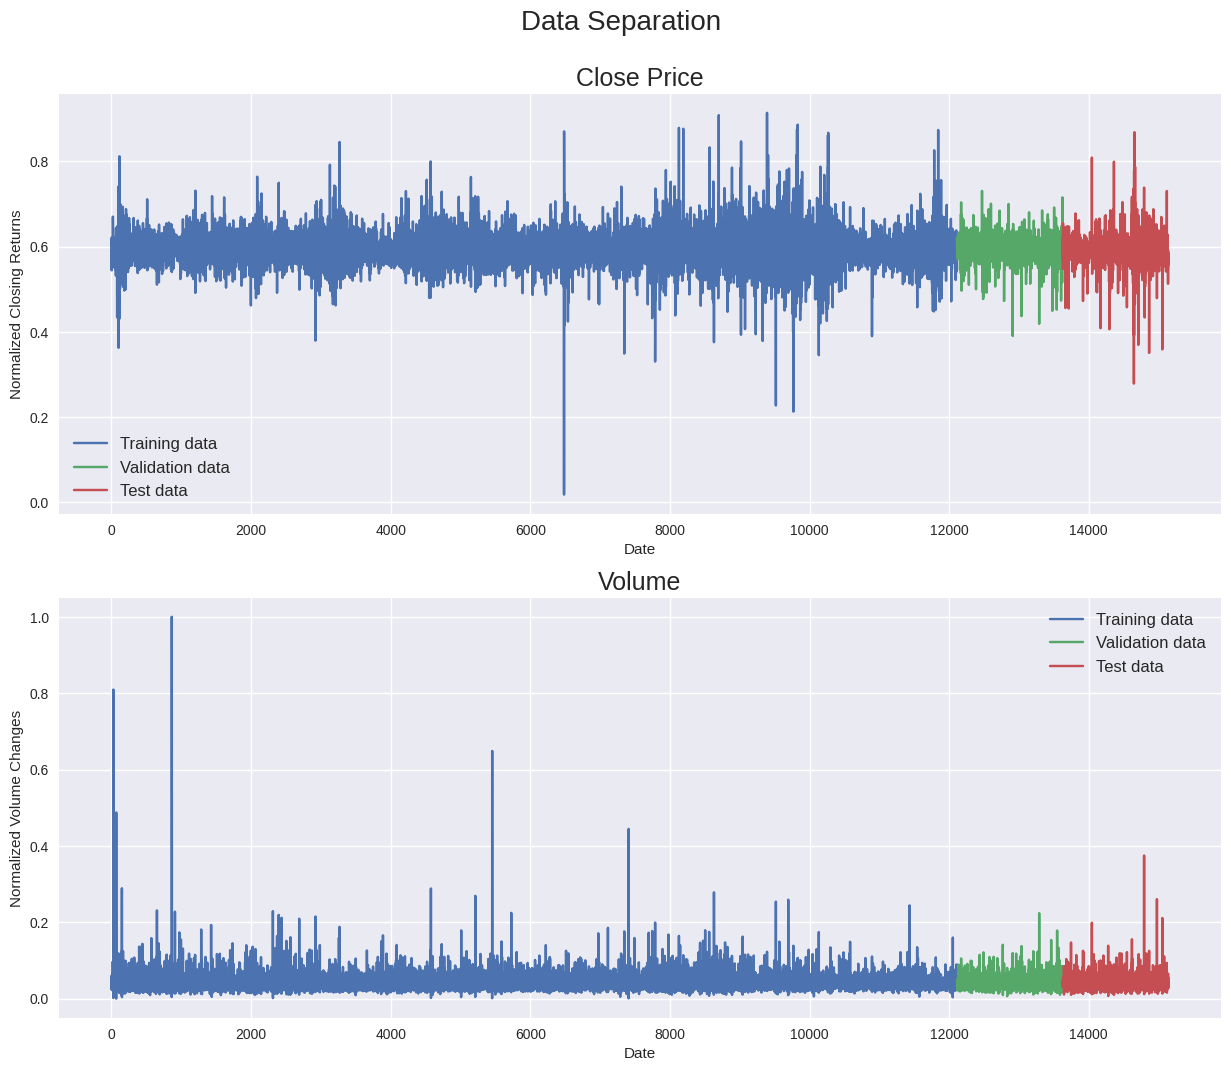

In [15]:
split_plot(df_train, df_val, df_test)

## "rolling window" or "sliding window" approach for time-series

Here we create sequences of data points, which we then use as an imput for training.

Sequence length parametr is important for Transformer.

"A longer sequence can capture longer-term dependencies, but it might also introduce more complexity and computation."

(Plan for sometime:

- Begin with an initial sequence length and use it for model training.

- Monitor the model's performance on the validation set using this sequence length.

- Experiment with different sequence lengths and train separate models with varying sequence lengths.)

In [16]:
seq_len = 8 # = 128 in other word timesteps

In [17]:
def chunks(df_train, df_val, df_test):

  df_train = df_train.values
  df_val = df_val.values
  df_test = df_test. values

  X_train, y_train = [], []
  # we use all colums for training. split data by subsets with "seq_len" rows and move by step = 1
  for i in range(seq_len, len(df_train)):
      X_train.append(df_train[i-seq_len:i])
      # we use only i-th value of 4th column (Close Price) as a target
      # nevertheless, we can predict all 5 parameters
      y_train.append(df_train[:, 3][i])
  X_train, y_train = np.array(X_train), np.array(y_train)


  X_val, y_val = [], []
  for i in range(seq_len, len(df_val)):
      X_val.append(df_val[i-seq_len:i])
      y_val.append(df_val[:, 3][i])
  X_val, y_val = np.array(X_val), np.array(y_val)


  X_test, y_test = [], []
  for i in range(seq_len, len(df_test)):
      X_test.append(df_test[i-seq_len:i])
      y_test.append(df_test[:, 3][i])
  X_test, y_test = np.array(X_test), np.array(y_test)

  print("Train chunks set shape: ", X_train.shape, y_train.shape)
  print("Val chunks set shape: ", X_val.shape, y_val.shape)
  print("Test chunks set shape: ", X_test.shape, y_test.shape)
  return(X_train, y_train, X_val, y_val, X_test, y_test)

In [18]:
# X_train, y_train, X_val, y_val, X_test, y_test = chunks(arr_train, arr_val, arr_test)
X_train, y_train, X_val, y_val, X_test, y_test = chunks(df_train, df_val, df_test)

Train chunks set shape:  (12104, 8, 5) (12104,)
Val chunks set shape:  (1506, 8, 5) (1506,)
Test chunks set shape:  (1507, 8, 5) (1507,)


## TimeEmbedding

ChatGPT: "Time embeddings can be a crucial component in a time-series Transformer model, especially when dealing with sequential data where the temporal order of the data points matters. Time embeddings help the model capture temporal patterns and dependencies in the data."

In [20]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    # 4 matrices: 2 by 2 for both non-periodical (linear) and the periodical (sin) features
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

# Model (tf realization)

model's imput [#batchs, #timesteps, features]

batchs -- how many stocks sequences we want to feed at once

With prepared tensorflow.layers Model (Kaggle_Teans & FordATS notebooks) it didn't work. Probably, cause it's not adapted for multiple time-series

In [21]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [22]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [23]:
def pred_plot(name_str, train_pred, val_pred, test_pred):

  fig = plt.figure(figsize=(15,20))
  st = fig.suptitle(name_str, fontsize=22)
  st.set_y(0.92)

  #Plot training data results
  ax11 = fig.add_subplot(311)
  ax11.plot(df_train.values[:, 3], label='IBM Closing Returns') # original data
  ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
  ax11.set_title("Training Data", fontsize=18)
  ax11.set_xlabel('Date')
  ax11.set_ylabel('IBM Closing Returns')
  ax11.legend(loc="best", fontsize=12)

  #Plot validation data results
  ax21 = fig.add_subplot(312)
  ax21.plot(df_val.values[:, 3], label='IBM Closing Returns')
  ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
  ax21.set_title("Validation Data", fontsize=18)
  ax21.set_xlabel('Date')
  ax21.set_ylabel('IBM Closing Returns')
  ax21.legend(loc="best", fontsize=12)

  #Plot test data results
  ax31 = fig.add_subplot(313)
  ax31.plot(df_test.values[:, 3], label='IBM Closing Returns')
  ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
  ax31.set_title("Test Data", fontsize=18)
  ax31.set_xlabel('Date')
  ax31.set_ylabel('IBM Closing Returns')
  ax31.legend(loc="best", fontsize=12)

### Hyperparametrs

In [35]:
batch_size = 32

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

### Without timeEmb.

In [24]:
# model without TimeEmb
def create_model_noTimEmb():
    # a hyperparameter, try different numbers of att lay
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, 5))
    x = attn_layer1((in_seq, in_seq, in_seq))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x) # regression head

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model

#### seq_len = 128

In [26]:
path_model_128 = '/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_128+noTimeEmb.hdf5'

In [58]:
model_128 = create_model_noTimEmb()
model_128.save(path_model_128)

callback = tf.keras.callbacks.ModelCheckpoint(path_model_128,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,  # Save the entire model (including architecture)
                                              verbose=1)

model_128.fit(X_train, y_train,
          batch_size=batch_size,
          epochs = 4,
          callbacks=callback,
          validation_data=(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/4
379/379 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.0905 - mape: 15.4667
Epoch 1: val_loss improved from inf to 0.00097, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_128+noTimeEmb.hdf5
379/379 [==============================] - 135s 212ms/step - loss: 0.0254 - mae: 0.0905 - mape: 15.4667 - val_loss: 9.6683e-04 - val_mae: 0.0226 - val_mape: 3.8110
Epoch 2/4
379/379 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0394 - mape: 6.9632
Epoch 2: val_loss did not improve from 0.00097
379/379 [==============================] - 75s 197ms/step - loss: 0.0027 - mae: 0.0394 - mape: 6.9632 - val_loss: 0.0011 - val_mae: 0.0249 - val_mape: 4.3379
Epoch 3/4
379/379 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0382 - mape: 6.7494
Epoch 3: val_loss did not improve from 0.00097
379/379 [==============================] - 93s 245ms/step - loss: 0.0026 - mae: 0.0382 - mape: 6.7494 - val_loss: 0.0012 -

In [27]:
loaded_model_128 = tf.keras.models.load_model(path_model_128,
                                         custom_objects={'SingleAttention': SingleAttention,
                                                         'MultiAttention': MultiAttention,
                                                         'TransformerEncoder': TransformerEncoder})

train_pred_mod128 = loaded_model_128.predict(X_train)
val_pred_mod128 = loaded_model_128.predict(X_val)
test_pred_mod128 = loaded_model_128.predict(X_test)

48/48 [==============================] - 4s 90ms/step


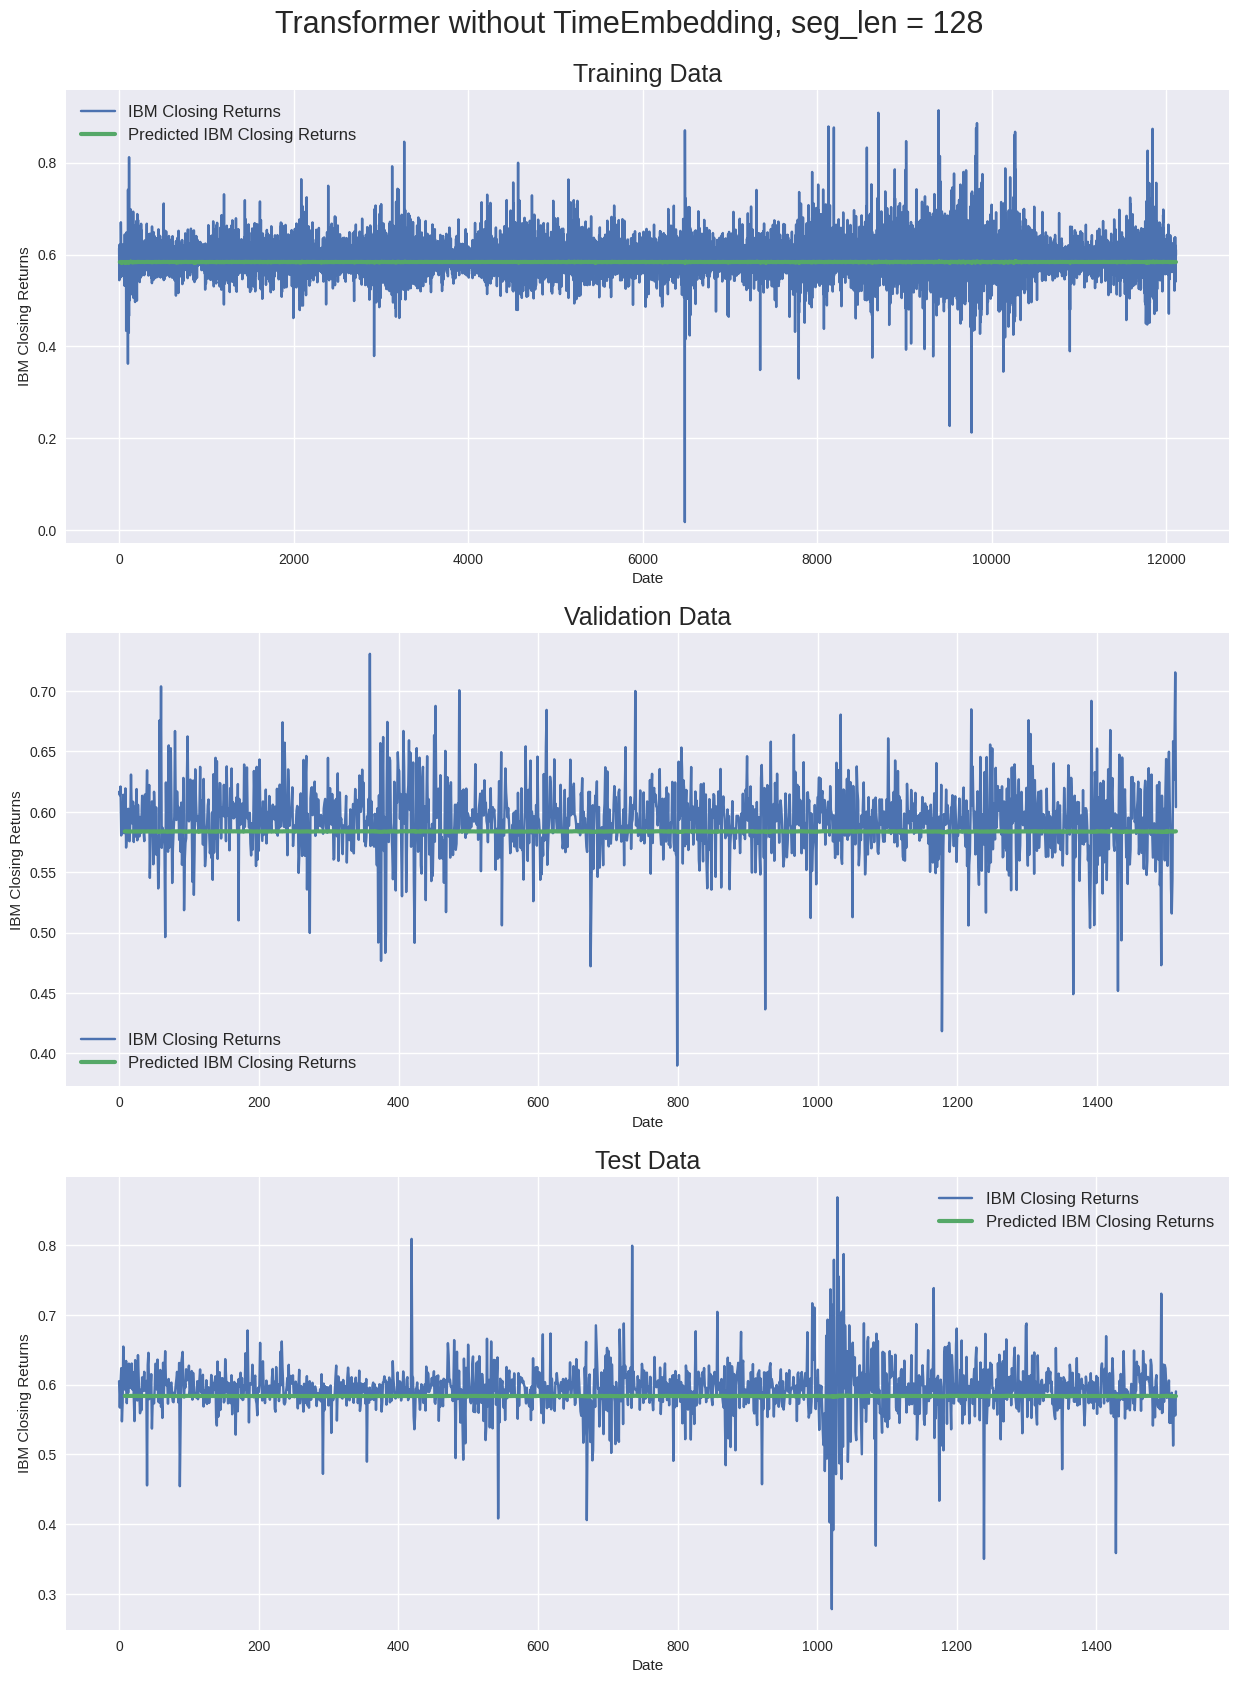

In [28]:
pred_plot("Transformer without TimeEmbedding, seg_len = 128", train_pred_mod128, val_pred_mod128, test_pred_mod128)

In [31]:
# train_pred_mod128

In [32]:
# df_train.values[:, 3]

#### seq_len = 8

In [33]:
path_model_8 = '/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_8+noTimeEmb.hdf5'

In [36]:
model_8 = create_model_noTimEmb()
model_8.save(path_model_8)

callback = tf.keras.callbacks.ModelCheckpoint(path_model_8,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,  # Save the entire model (including architecture)
                                              verbose=1)

model_8.fit(X_train, y_train,
          batch_size=batch_size,
          epochs = 4,
          callbacks=callback,
          validation_data=(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/4
379/379 [==============================] - ETA: 0s - loss: 0.0197 - mae: 0.0796 - mape: 13.7070
Epoch 1: val_loss improved from inf to 0.00100, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_8+noTimeEmb.hdf5
379/379 [==============================] - 158s 266ms/step - loss: 0.0197 - mae: 0.0796 - mape: 13.7070 - val_loss: 9.9970e-04 - val_mae: 0.0232 - val_mape: 3.9013
Epoch 2/4
379/379 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0413 - mape: 7.2844
Epoch 2: val_loss improved from 0.00100 to 0.00096, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/Transf_8+noTimeEmb.hdf5
379/379 [==============================] - 75s 198ms/step - loss: 0.0029 - mae: 0.0413 - mape: 7.2844 - val_loss: 9.6460e-04 - val_mae: 0.0226 - val_mape: 3.8053
Epoch 3/4
379/379 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0383 - mape: 6.7588
Epoch 3: val_loss did not improve from 0.00096
379/379 [==========

In [37]:
# Load the model from the Google Drive
loaded_model_8 = tf.keras.models.load_model(path_model_8,
                                         custom_objects={'SingleAttention': SingleAttention,
                                                         'MultiAttention': MultiAttention,
                                                         'TransformerEncoder': TransformerEncoder})

train_pred_mod8 = loaded_model_8.predict(X_train)
val_pred_mod8 = loaded_model_8.predict(X_val)
test_pred_mod8 = loaded_model_8.predict(X_test)

48/48 [==============================] - 3s 52ms/step


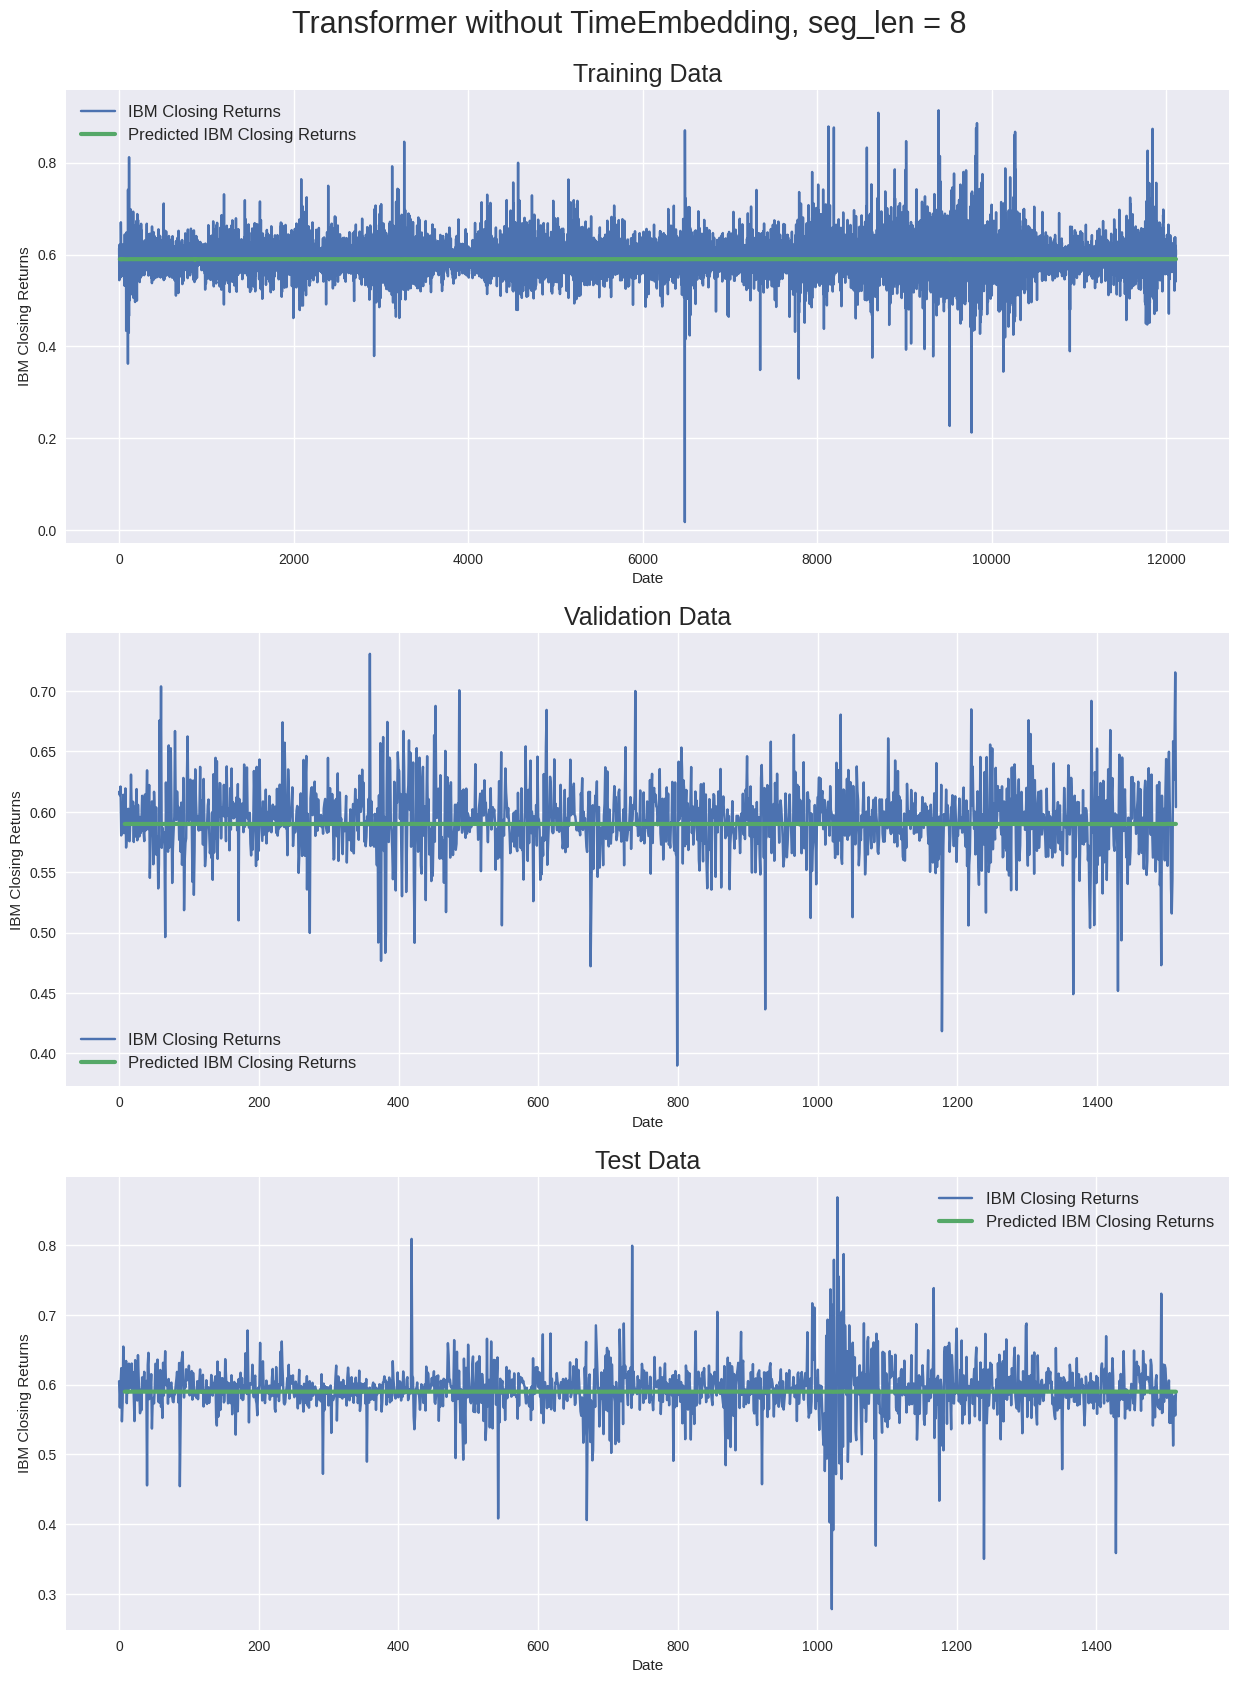

In [38]:
pred_plot("Transformer without TimeEmbedding, seg_len = 8", train_pred_mod8, val_pred_mod8, test_pred_mod8)

### With TimeEmb (later)

Code with timeEmb (without data normalization) gives sooner less loss than without. But still loss is big.

In [128]:
# model with TimeEmb
def create_model_TimeEmb():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model

In [ ]:
modelEbm = create_model()
modelEbm.summary()

# callback = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# checkpoint_callback = ModelCheckpoint(
#     filepath='model_checkpoint.h5',  # Filepath for saving the checkpoints
#     save_best_only=True,  # Save only the best model based on a monitored metric
#     monitor='val_loss',  # Metric to monitor for saving the best model
#     save_weights_only=False,  # Save the entire model (including architecture)
#     verbose=1  # Display progress messages
# )

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding+TimeEmb.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

modelEbm.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=4,
          callbacks=callback,
          validation_data=(X_val, y_val))

# model.evaluate(X_test, y_test, verbose=1)

modelEbm = tf.keras.models.load_model('/content/Transformer+TimeEmbedding+TimeEmb.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 5)]             0         []                            
                                                                                                  
 time2_vector (Time2Vector)  (None, 128, 2)               512       ['input_3[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 128, 7)               0         ['input_3[0][0]',             
                                                                     'time2_vector[0][0]']        
                                                                                                  
 transformer_encoder_9 (Tra  (None, 128, 7)               99114     ['concatenate[0][0]',   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 1041s 3s/step - loss: 0.0197 - mae: 0.0760 - mape: 13.1352 - val_loss: 9.0425e-04 - val_mae: 0.0214 - val_mape: 3.6990
Epoch 2/4
375/375 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0422 - mape: 7.4609
Epoch 2: val_loss improved from 0.00090 to 0.00089, saving model to Transformer+TimeEmbedding+TimeEmb.hdf5
375/375 [==============================] - 982s 3s/step - loss: 0.0030 - mae: 0.0422 - mape: 7.4609 - val_loss: 8.8530e-04 - val_mae: 0.0211 - val_mape: 3.6185
Epoch 3/4
375/375 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0415 - mape: 7.2796
Epoch 3: val_loss did not improve from 0.00089
375/375 [==============================] - 1013s 3s/step - loss: 0.0029 - mae: 0.0415 - mape: 7.2796 - val_loss: 0.0012 - val_mae: 0.0263 - val_mape: 4.5967
Epoch 4/4
375/375 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0401 - mape: 7.0720
Epoch 4: val_loss did not improve from 0.00089
375/3

In [ ]:
#Calculate predication for training, validation and test data
train_predEmb = modelEbm.predict(X_train)
val_predEmb = modelEbm.predict(X_val)
test_predEmb = modelEbm.predict(X_test)

44/44 [==============================] - 38s 859ms/step


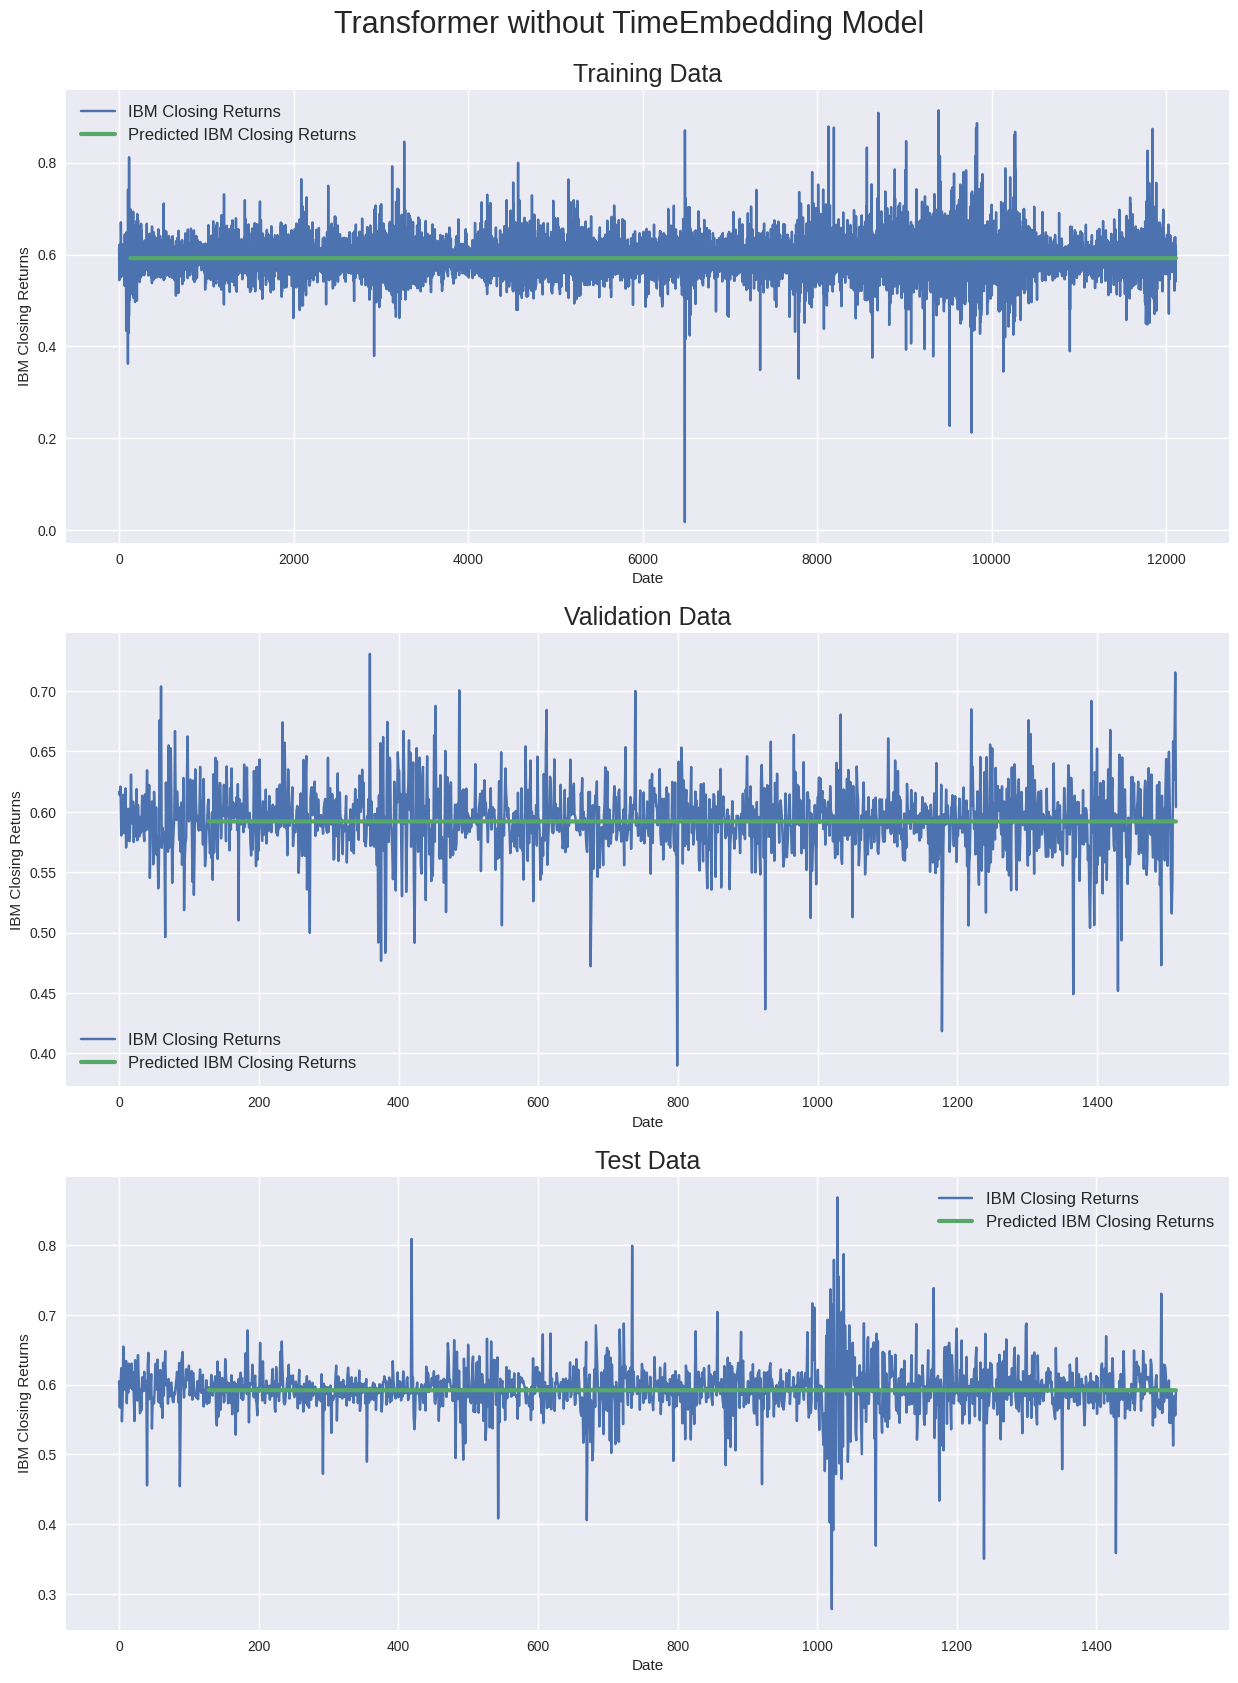

In [ ]:
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer without TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_arr[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_predEmb.shape[0]+seq_len), train_predEmb, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_arr[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_predEmb.shape[0]+seq_len), val_predEmb, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_arr[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_predEmb.shape[0]+seq_len), test_predEmb, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

# Data w/ Rolling Windows

In [119]:
df_RW = stocks_data.copy()

# Moving average with a window of 10 days to all columns
df_RW[['Open', 'High', 'Low', 'Close', 'Volume']] = stocks_data[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean()

df_RW.dropna(how='any', axis=0, inplace=True)
df_RW.head()

,DateTime,Open,High,Low,Close,Volume
9,1962-01-15 14:30:00,7.208413,7.245061,7.159337,1.550373,384405.0
10,1962-01-16 14:30:00,7.192479,7.229127,7.144678,1.547210,370284.0
11,1962-01-17 14:30:00,7.174633,7.204908,7.116635,1.540195,383620.5
12,1962-01-18 14:30:00,7.144041,7.181326,7.093690,1.535175,395388.0
13,1962-01-19 14:30:00,7.121734,7.160930,7.078394,1.533387,399310.5


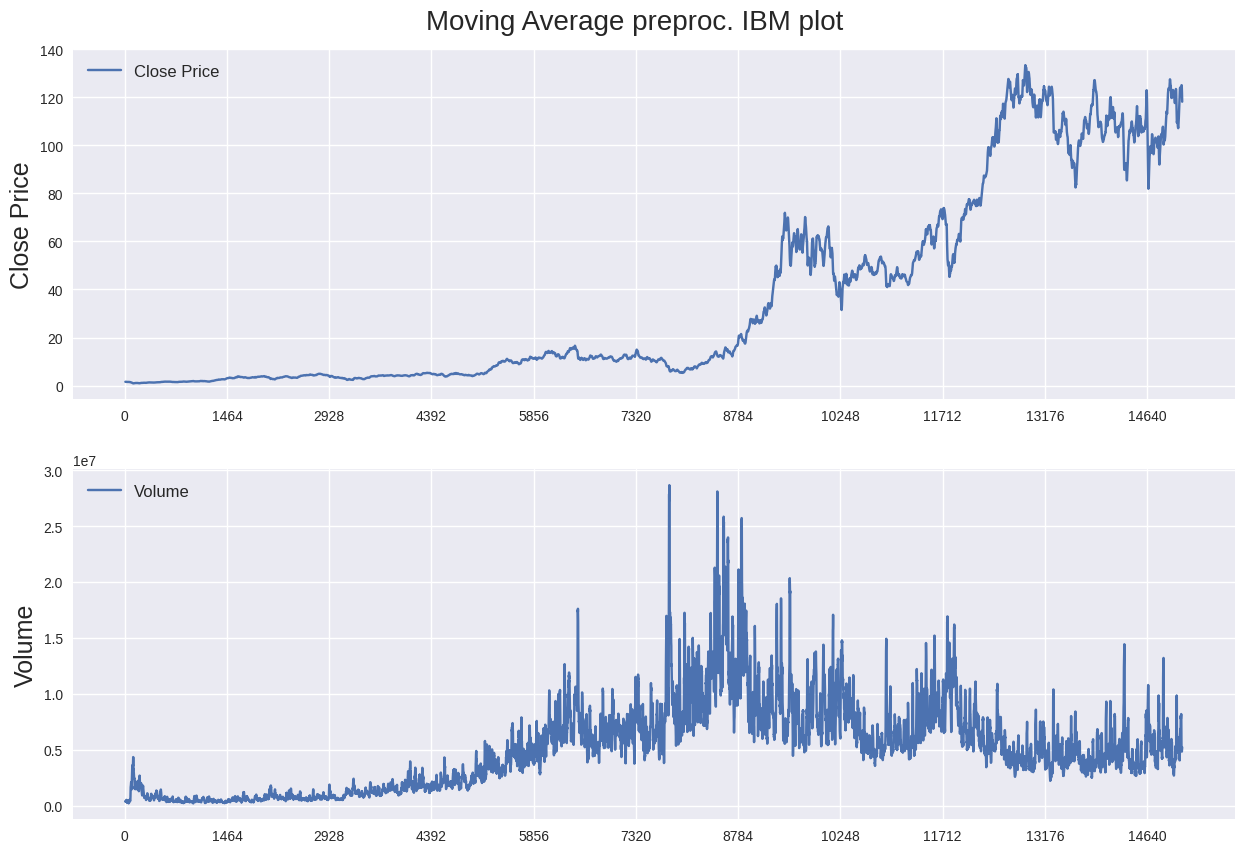

In [130]:
stock_plot("Moving Average preproc. IBM plot", df_RW)

Train df shape: (12105, 5)
Val df shape: (1513, 5)
Test df shape: (1514, 5)


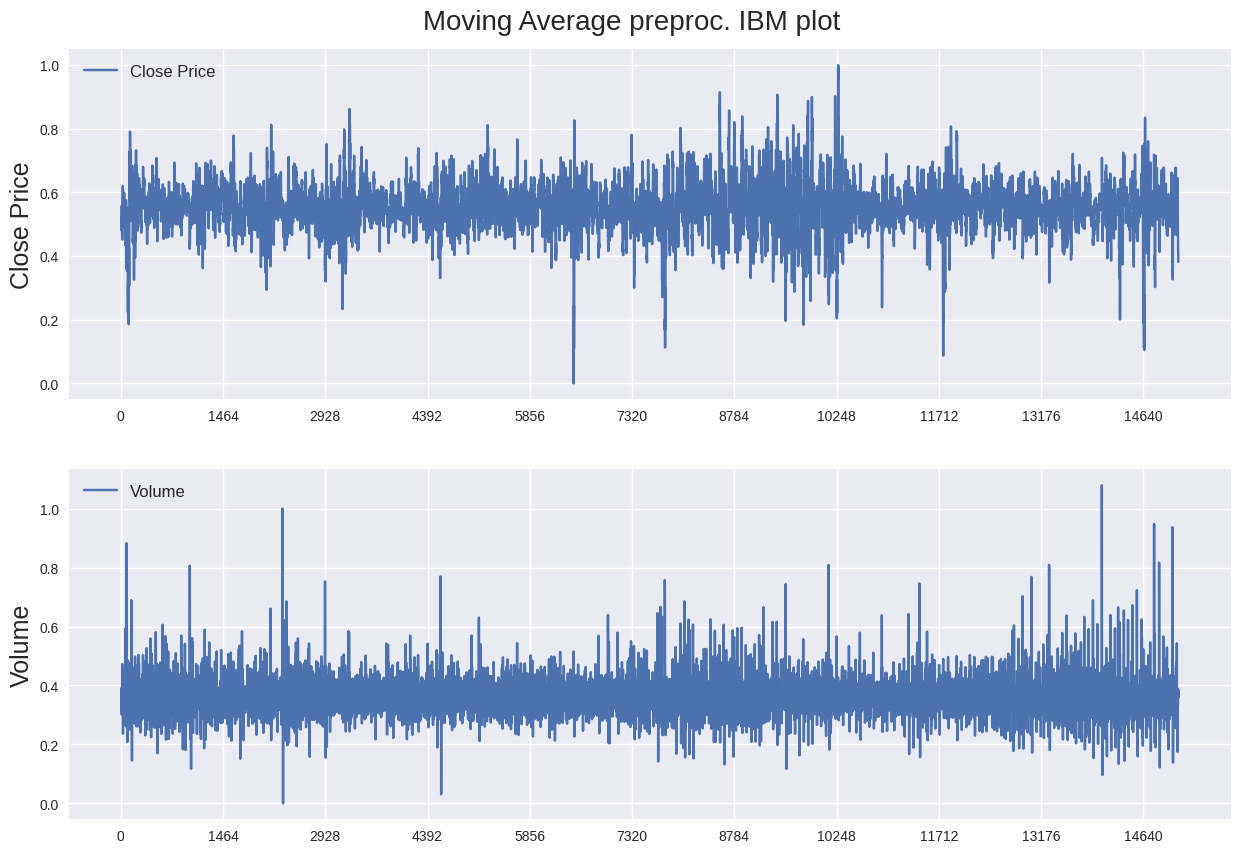

In [129]:
conv_df_RW = df_convert(df_RW)
preproc_df_RW = normaliz(conv_df_RW)
stock_plot("Moving Average preproc. IBM plot", preproc_df_RW)

dfRW_train, dfRW_val, dfRW_test, arrRW_train, arrRW_val, arrRW_test = df_split(preproc_df_RW)

In [127]:
RWX_train, RWy_train, RWX_val, RWy_val, RWX_test, RWy_test = chunks(arrRW_train, arrRW_val, arrRW_test)

Train chunks set shape:  (12097, 8, 5) (12097,)
Val chunks set shape:  (1505, 8, 5) (1505,)
Test chunks set shape:  (1506, 8, 5) (1506,)


In [132]:
RW_path = '/content/drive/My Drive/Colab Notebooks/MultiTimeSeries/TransformerRW.hdf5'

In [133]:
model_RW = create_model_TimeEmb()
model_RW.save(RW_path)

callback = tf.keras.callbacks.ModelCheckpoint(RW_path,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,  # Save the entire model (including architecture)
                                              verbose=1)

model_RW.fit(RWX_train, RWy_train,
          batch_size=batch_size,
          epochs = 4,
          callbacks=[callback],
          validation_data=(RWX_val, RWy_val))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/4
378/379 [============================>.] - ETA: 0s - loss: 0.0243 - mae: 0.0960 - mape: 39638.5039
Epoch 1: val_loss improved from inf to 0.00269, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/TransformerRW.hdf5
379/379 [==============================] - 140s 236ms/step - loss: 0.0243 - mae: 0.0960 - mape: 39635.2305 - val_loss: 0.0027 - val_mae: 0.0438 - val_mape: 8.3119
Epoch 2/4
378/379 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0494 - mape: 35049.3320
Epoch 2: val_loss did not improve from 0.00269
379/379 [==============================] - 71s 187ms/step - loss: 0.0042 - mae: 0.0494 - mape: 35046.4375 - val_loss: 0.0033 - val_mae: 0.0497 - val_mape: 9.1783
Epoch 3/4
378/379 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0436 - mape: 35860.8828
Epoch 3: val_loss improved from 0.00269 to 0.00222, saving model to /content/drive/My Drive/Colab Notebooks/MultiTimeSeries/TransformerRW.hdf5
379/379 [==========

In [134]:
modelRW = tf.keras.models.load_model(RW_path,
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

48/48 [==============================] - 2s 50ms/step


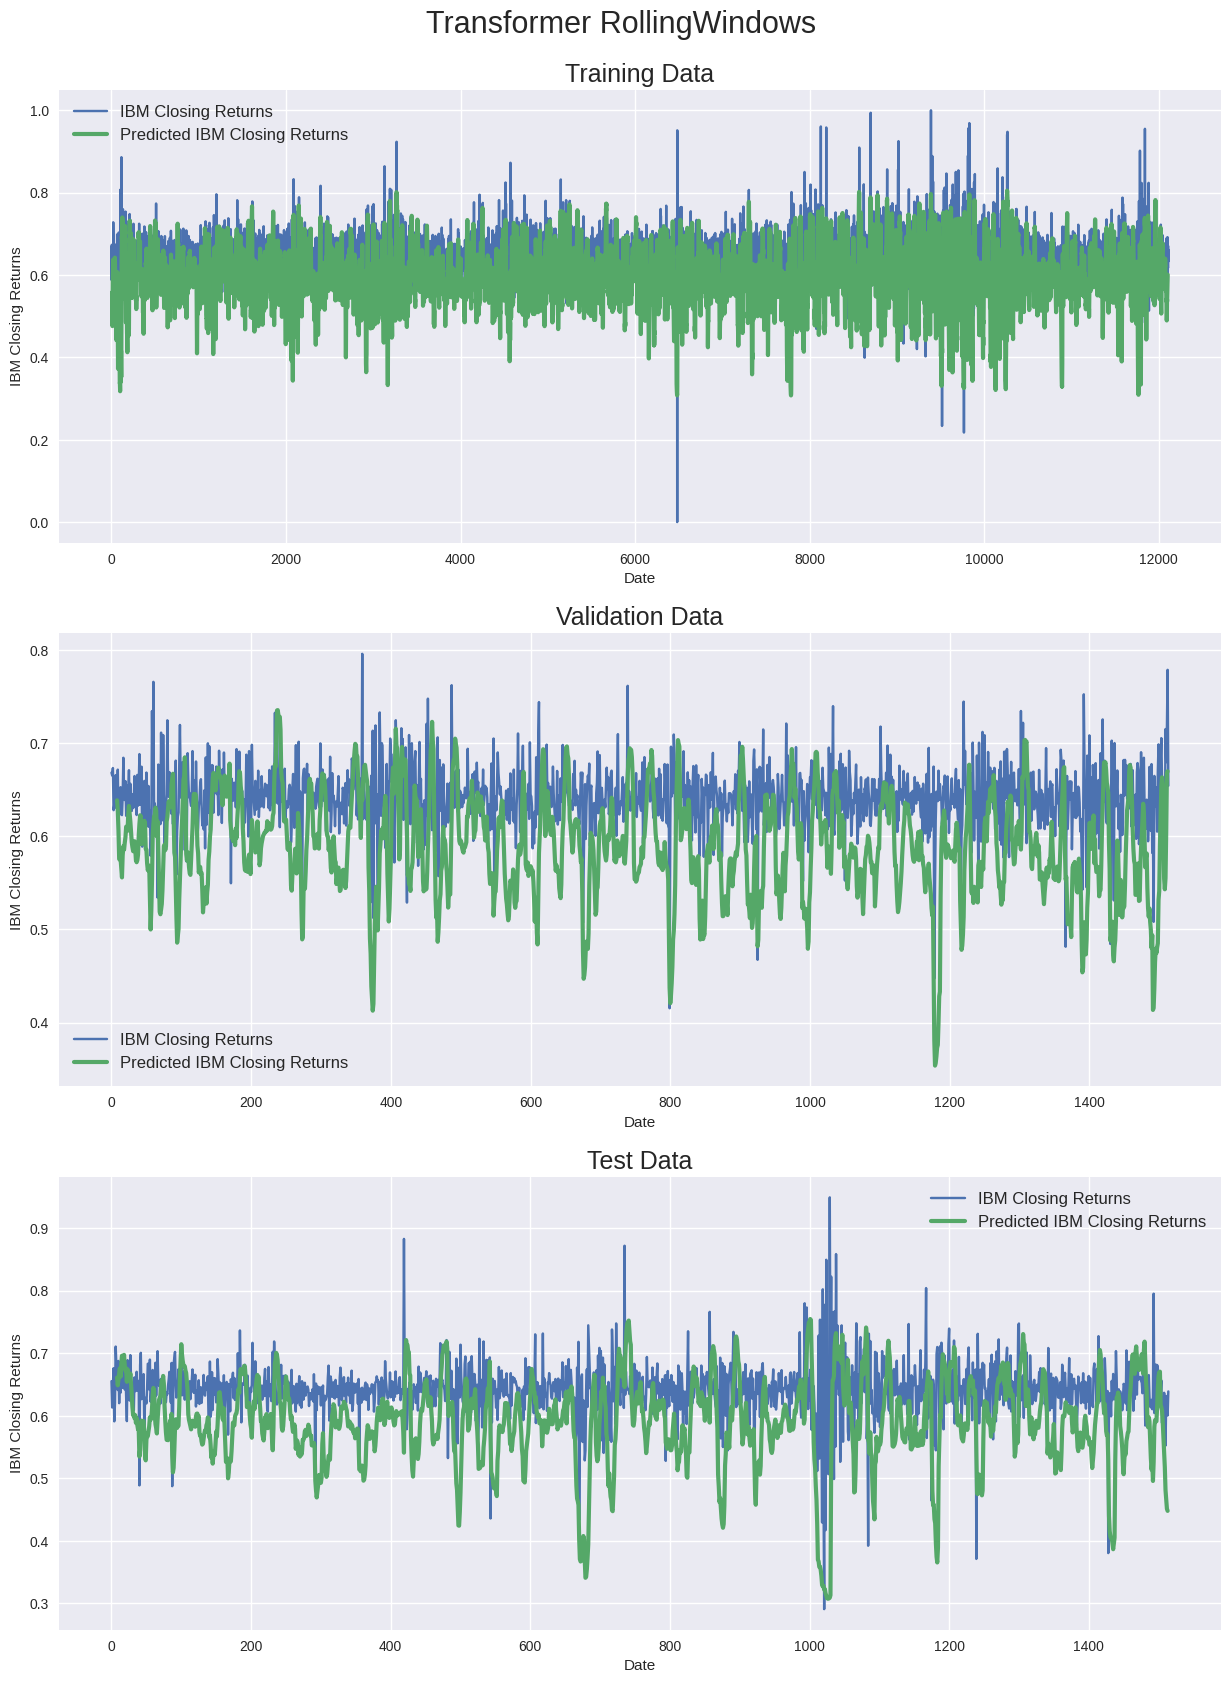

In [135]:
train_predRW = modelRW.predict(RWX_train)
val_predRW = modelRW.predict(RWX_val)
test_predRW = modelRW.predict(RWX_test)

pred_plot("Transformer RollingWindows", train_predRW, val_predRW, test_predRW)

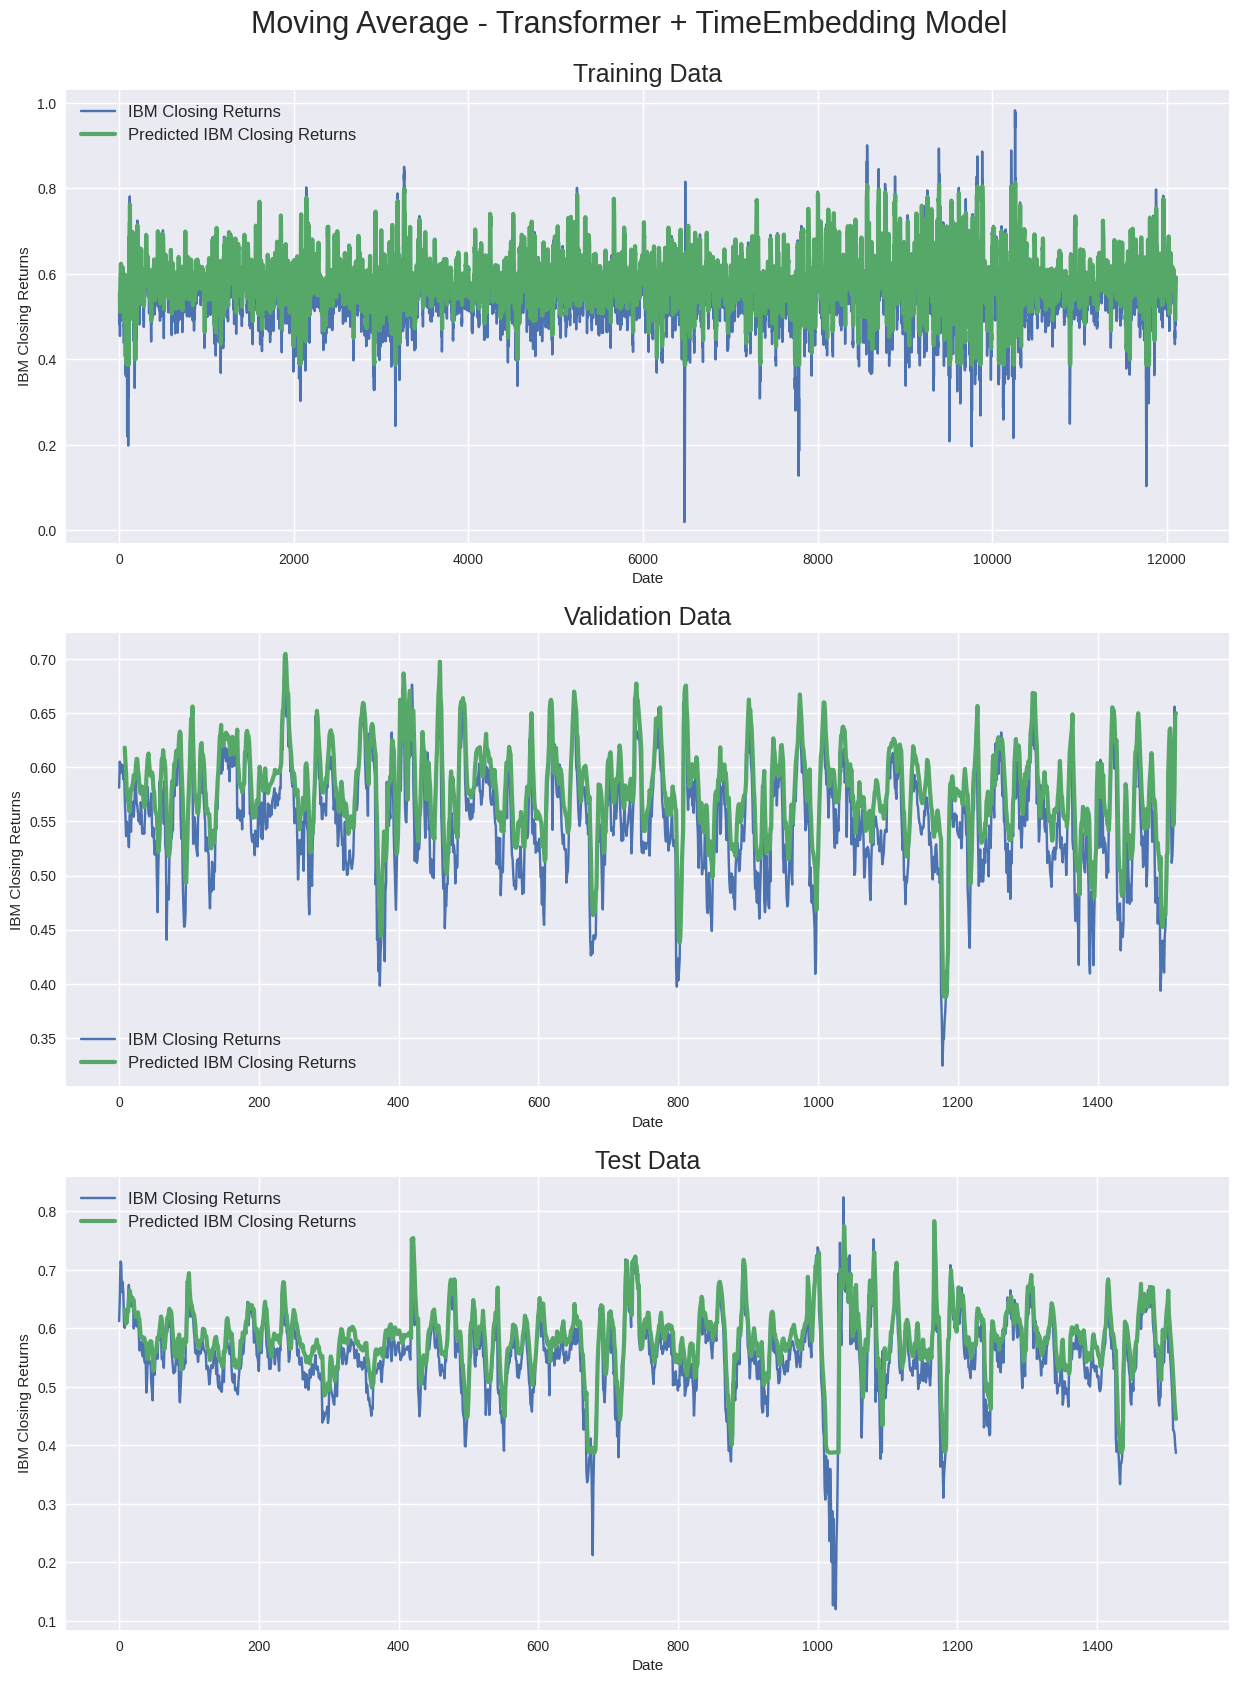

In [41]:
# fig = plt.figure(figsize=(15,20))
# st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
# st.set_y(0.92)

# #Plot training data results
# ax11 = fig.add_subplot(311)
# ax11.plot(RWtrain_arr[:, 3], label='IBM Closing Returns')
# ax11.plot(np.arange(seq_len, train_predRW.shape[0]+seq_len), train_predRW, linewidth=3, label='Predicted IBM Closing Returns')
# ax11.set_title("Training Data", fontsize=18)
# ax11.set_xlabel('Date')
# ax11.set_ylabel('IBM Closing Returns')
# ax11.legend(loc="best", fontsize=12)

# #Plot validation data results
# ax21 = fig.add_subplot(312)
# ax21.plot(RWval_arr[:, 3], label='IBM Closing Returns')
# ax21.plot(np.arange(seq_len, val_predRW.shape[0]+seq_len), val_predRW, linewidth=3, label='Predicted IBM Closing Returns')
# ax21.set_title("Validation Data", fontsize=18)
# ax21.set_xlabel('Date')
# ax21.set_ylabel('IBM Closing Returns')
# ax21.legend(loc="best", fontsize=12)

# #Plot test data results
# ax31 = fig.add_subplot(313)
# ax31.plot(RWtest_arr[:, 3], label='IBM Closing Returns')
# ax31.plot(np.arange(seq_len, test_predRW.shape[0]+seq_len), test_predRW, linewidth=3, label='Predicted IBM Closing Returns')
# ax31.set_title("Test Data", fontsize=18)
# ax31.set_xlabel('Date')
# ax31.set_ylabel('IBM Closing Returns')
# ax31.legend(loc="best", fontsize=12)